# Imports

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
X_train = pd.read_csv('./data/X_train.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_internal = pd.read_csv('./data/X_test_internal.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_external = pd.read_csv('./data/X_test_external.csv', usecols=['GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')

# Fit logistic regression model

In [3]:
log_reg_model = LogisticRegression(random_state=0).fit(X_train, Y_train)

/Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Get model coefficients

In [12]:
print(log_reg_model.coef_)

[[-1.00125023e-04  1.67728345e-01 -2.00931798e-02]]


In [8]:
print(np.exp(log_reg_model.coef_))

[[0.99989988 1.1826153  0.98010734]]


In [11]:
print(log_reg_model.intercept_)

[0.47852542]


In [10]:
print(np.exp(log_reg_model.intercept_) / (1 + np.exp(log_reg_model.intercept_)))

[0.61739961]


In [7]:
print(log_reg_model.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)>


# Make binary class and probabilistic predictions

In [106]:
# Make class predictions on internal/external test sets
Y_train_class_pred = log_reg_model.predict(X_train)
Y_test_internal_class_pred = log_reg_model.predict(X_test_internal)
Y_test_external_class_pred = log_reg_model.predict(X_test_external)

# Make probabilistic predictions on internal/external test sets
Y_train_prob_pred = log_reg_model.predict_proba(X_train)[:, 1]
Y_test_internal_prob_pred = log_reg_model.predict_proba(X_test_internal)[:, 1]
Y_test_external_prob_pred = log_reg_model.predict_proba(X_test_external)[:, 1]

# Save predictions as .csv
Y_train_pred = pd.DataFrame({'class_pred':Y_train_class_pred, 'prob_pred':Y_train_prob_pred})
Y_train_pred.to_csv('./data/log_reg_train_predictions.csv', index=False)

Y_test_internal_pred = pd.DataFrame({'class_pred':Y_test_internal_class_pred, 'prob_pred':Y_test_internal_prob_pred})
Y_test_internal_pred.to_csv('./data/log_reg_test_internal_predictions.csv', index=False)

Y_test_external_pred = pd.DataFrame({'class_pred':Y_test_external_class_pred, 'prob_pred':Y_test_external_prob_pred})
Y_test_external_pred.to_csv('./data/log_reg_test_external_predictions.csv', index=False)

In [107]:
print(Y_train_prob_pred.shape)

(1989224,)


# Evaluate results

In [108]:
# Classification reports
train_classification_report = classification_report(Y_train, Y_train_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_internal_classification_report = classification_report(Y_test_internal, Y_test_internal_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_external_classification_report = classification_report(Y_test_external, Y_test_external_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)

In [109]:
print(train_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7133    0.5905    0.6461    779434
Home Team Win     0.7625    0.8471    0.8026   1209790

     accuracy                         0.7465   1989224
    macro avg     0.7379    0.7188    0.7243   1989224
 weighted avg     0.7432    0.7465    0.7413   1989224



In [110]:
print(test_internal_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7434    0.5984    0.6631     96760
Home Team Win     0.7354    0.8439    0.7859    128011

     accuracy                         0.7382    224771
    macro avg     0.7394    0.7211    0.7245    224771
 weighted avg     0.7389    0.7382    0.7331    224771



In [111]:
print(test_external_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7389    0.6089    0.6676    104262
Home Team Win     0.7182    0.8225    0.7668    126379

     accuracy                         0.7259    230641
    macro avg     0.7285    0.7157    0.7172    230641
 weighted avg     0.7276    0.7259    0.7220    230641



In [112]:
# Calculate log loss
train_log_loss = log_loss(Y_train, Y_train_prob_pred)
test_internal_log_loss = log_loss(Y_test_internal, Y_test_internal_prob_pred)
test_external_log_loss = log_loss(Y_test_external, Y_test_external_prob_pred)

In [113]:
print(train_log_loss)

0.5019751893280499


In [114]:
print(test_internal_log_loss)

0.5184425528288314


In [115]:
print(test_external_log_loss)

0.5276979482386669


In [116]:
# Plot and calculate area under ROC curve

def plot_roc_curve(true, pred, title):
    fpr, tpr, threshold = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('{} ROC Curve'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

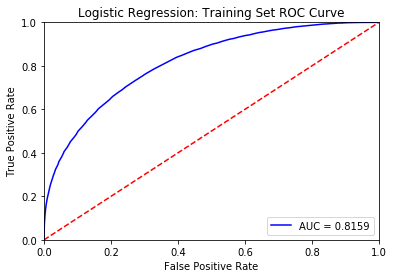

In [117]:
plot_roc_curve(Y_train, Y_train_prob_pred, 'Logistic Regression: Training Set')

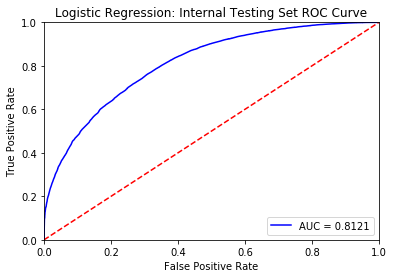

In [118]:
plot_roc_curve(Y_test_internal, Y_test_internal_prob_pred, 'Logistic Regression: Internal Testing Set')

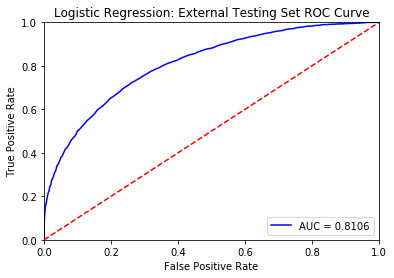

In [119]:
plot_roc_curve(Y_test_external, Y_test_external_prob_pred, 'Logistic Regression: External Testing Set')